# Advanced basics

In this notebook, we'll go over some very slightly more advanced concepts in quantum computing. You've seen that Clifford circuits can be effiently simulated; this is the Gottesman–Knill theorem. We want therefore to look into a kind of gate which provides not only the _magic_ (or non-stabilizerness) of quantum circuits, but also the the ability to create hybrid algorithms: parametrized gates.

In this notebook, we'll go over simple parametrized gates and a very simple optimization example.

Again, let's start by installing qiskit, as usual.

In [1]:
%pip install qiskit[visualization] --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Parametrized gates

In this notebook, we'll consider three parametrized gates which are derived from Paulis: they are the exponentiated gates, i.e.
$R\sigma_j(\theta) = e^{i\theta \sigma_j}$, where $j=X,Y,Z$ (the Pauli matrices). It is reasonable to ask how to implement those, and luckily there's a closed form we can get from the power expansion of the exponential. Then, we have
$e^{i\theta \sigma_j} = \cos(\theta) I + i\sin(\theta) \sigma_j$. 

For example, $RZ(\theta)$ can be expressed in matrix form as

$$RZ(\theta) = \begin{pmatrix} \cos(\theta) + i\sin(\theta) & 0 \\ 0 & \cos(\theta) - i\sin(\theta) \end{pmatrix} = \begin{pmatrix} e^{i\theta} & 0 \\ 0 & e^{-i\theta} \end{pmatrix}$$

All good, then let's see how that works in qiskit. 

We'll create a single qubit, apply a Hadamard gate, and then apply the $RZ$ gate to see how that affects the evolution. Note that in Qiskit there's a $1/2$ factor in the argument, such that $RZ_{qiskit}(\theta) = RZ_{normal}(2\theta)$. The reason for that is the simplification of the $\sin$ and $\cos$ function when you express them in exponentials. We'll see that later.


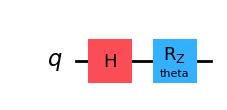

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

num_qubits = 1
theta = Parameter("theta")

circuit = QuantumCircuit(num_qubits)
circuit.h(0)
circuit.rz(theta,0)
circuit.draw("mpl")

We expect this should change the sign of the superposition like so: $\exp(i\theta/2)|0\rangle + \exp(-i\theta/2)|1\rangle$, as $\theta$ is varied. Let's check that it is the case by observing the phase. 

We need to define a few functions for that, one to get the values, and one to plot them.

In [3]:
from qiskit.primitives import StatevectorEstimator
import numpy as np
import matplotlib.pyplot as plt

def estimate_observables(
    circuit: QuantumCircuit, observables: list, param_sweep: np.ndarray
):
    estimator = StatevectorEstimator()
    pub = (circuit, observables, param_sweep)
    job = estimator.run([pub])
    result = job.result()[0]
    return result

# plot result of simulation
def plot_estimator_result(param_sweep,result, observables,overlay_x=None,overlay_y=None,overlay_label:str=None):
    fig, ax = plt.subplots()
    ax:plt.Axes

    for evs,stds,obs in zip(result.data.evs,result.data.stds,observables):
        ax.errorbar(param_sweep, evs,stds, label=f"Observable {obs[0].paulis[0]}")
    
    # adding this to plot the expected function as an overlay here
    if overlay_x is not None and overlay_y is not None:
        ax.plot(overlay_x, overlay_y,"rx",alpha=.8,linewidth=2,label=overlay_label)
    
    ax.legend()
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("Expectation value")
    ax.set_xlim([-np.pi,np.pi])
    plt.show()


We've defined a function that estimate an observable for a given array of parameter values (the `param_sweep`), and a function that plot these results. 

Now let's sweep the observable $X$, and plot it in blue to see how the phase evolves with theta. We said before that the phase would follow some exponential expression; we can thus find an actual expression for the expectation value $\langle\psi(\theta)|X|\psi(\theta)\rangle$ (which I encourage you to rederive), and which we find to be $\cos(\theta)$ (remember the $1/2$ factor?). Okay, so let's plot that too

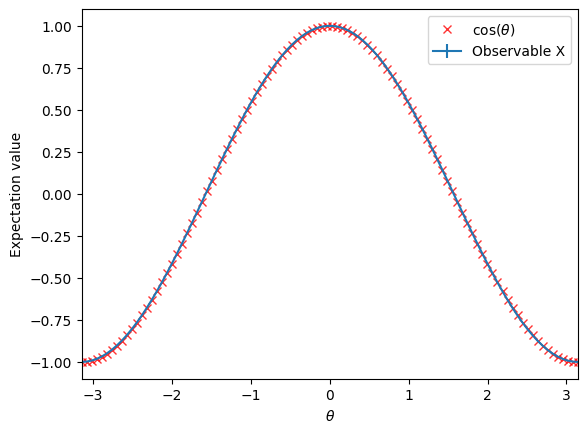

In [4]:
from qiskit.quantum_info import SparsePauliOp 

param_sweep = np.linspace(-np.pi,np.pi,100)
phase = np.cos(param_sweep)
observable = [[SparsePauliOp("X")]]

result  = estimate_observables(circuit,observable,param_sweep)
plot_estimator_result(param_sweep,result,observable,overlay_x=param_sweep,overlay_y=phase,overlay_label=r"$\cos(\theta)$")

So far so good. We've got the result we expected. As we thought, the expectation of $X$ follows $\cos(\theta)$, and reaches its minimal value at $\theta=\pi$. 

## Variational Quantum Eigensolver

Now, we can imagine that we are interested in looking for that minimal value, without yet knowing how the expectation values depend on the parameters. But we can search for the minimizig parameters: we use a classical optimization algorithm to minimize the parameters of some quantum circuit. This we call a *variational quantum eigensolver*. 

Usually, the observable we want to minimize is the energy of some Hamiltonian. In that case, we're in fact looking for the ground state of our system! 

Let's try this out. We'll first write some function that defines our Hamiltonian, which is also the observable we want to minimize. Let's go with a simple model (which is called the transverse field Ising model). The Hamiltonian is

$$ H = -J\sum_{\langle i,j \rangle} Z_i Z_{j} + g\sum_j X_j

In [5]:
num_qubits = 10
J=2
g=1

hamiltonian_J = sum([-J*SparsePauliOp(s*"I"+"ZZ"+(num_qubits-2-s)*"I") for s in range(num_qubits-1)])
hamiltonian_g = sum([g*SparsePauliOp(s*"I"+"X"+(num_qubits-1-s)*"I") for s in range(num_qubits-1)])

hamiltonian = hamiltonian_J + hamiltonian_g

We need to define the routine to optimize the quantum circuit. We'll use the scipy library to do just that. 

We need a function that optimizes the parameters based on the expectation value, and another one that gives us the true minimal energy, so that we can actually compare.

In [34]:
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh

def optimize_circuit(circuit:QuantumCircuit,hamiltonian:SparsePauliOp)->list:
    energy_values=[]
    def callback(xk:np.ndarray):
        energy_values.append(fun(xk=xk))
    def fun(xk:np.ndarray):
        result = estimate_observables(circuit=circuit,observables=[hamiltonian],param_sweep=xk)
        return result.data.evs[0]
    minimize(fun=fun,x0=np.zeros((len(circuit.parameters))),method="Nelder-Mead",callback=callback)
    return energy_values

def true_ground_energy(hamiltonian:SparsePauliOp):
    mat=hamiltonian.to_matrix(sparse=True)
    ground_energy,_=eigsh(mat,k=1,which="SA")
    return ground_energy



## Exercise

Finally, we need a quantum circuit to optimize, which, hopefully can express the correct value. 

Now I let the definition of that circuit up to you. Rememeber, this is a quantum Hamiltonian we're trying to solve: you need to make use of superposition, entanglement, and parametrized gates. Your circuit needs to be able to express the ground state.


In [35]:
from uuid import uuid1
# protip: when creating parameters for your circuit, use Parameter(name=str(uuid1())) to name them automatically
# you can also create a circuit and repeat it multiple times to make it more expressive.
# though this will mean the training takes longer, and it makes the circuit deeper (which you want to avoid.)
# the depth is printed when you run this cell

ground_energy = true_ground_energy(hamiltonian)


def your_circuit():
    circuit = QuantumCircuit(num_qubits)
    n_layers= 10
    for _ in range(n_layers):
        for x in range(num_qubits):
            param=Parameter(name=str(uuid1()))
            circuit.rx(param,x)
        for x,y in zip(range(num_qubits-1),range(1,num_qubits)):
            circuit.cx(x,y)


    return circuit


circuit = your_circuit()
print(f"The circuit depth is {circuit.depth()}")

energy_values = optimize_circuit(circuit,hamiltonian)

fig,ax = plt.subplots()

ax.plot(list(range(len(energy_values))),np.abs(energy_values-ground_energy))
ax.set_xlabel("Iterations")
ax.set_ylabel("$|E_{optim}-E_{true}|$")
ax.set_yscale("log")



The circuit depth is 37
